# Planteamiento del Problema

A continuación se presenta un analisis bivariado basado en datos de consumo de energía eléctrica horaria registrados en Cali, Colombia, junto con las temperaturas correspondientes a cada hora. El objetivo principal es explorar la relación entre estas dos variables.

## Contexto

La demanda de energía eléctrica en una ciudad se ve inlfuenciada por muchos factores, como la temperatura, factores sociales, cronograma de produccion de grandes clientes, entre otros.

En regiones con climas variables, como es el caso de muchas ciudades Colombianas, la demanda es afectada por el uso intensivo de sistemas de refrigeración en épocas calurosas.

# Selección de las variables y justificación


En primer lugar, el análisis de la matriz de correlación entre temperatura y consumo evidencia que existe una relación moderada entre ambas variables, este posee un coeficiente de correlación de 0.59, lo que indica que a medida que la temperatura aumenta, el consumo de energía es directamente proporcional, a pesar de que no tiene un comportamiento totalmente lineal. En concordancia con lo anterior, el análisis de jerarquía en las características evidencia que la variable más predominante en el consumo de energía es la hora del día.

Lo mencionado anteriormente se puede evidenciar que existe una tendencia, el consumo sigue un horario acorde con el marcado eléctrico, con rangos horarios del día donde se incrementa significativamente. Adicionalmente, factores como el día de la semana especialmente los días ordinarios o festivos pudiesen ser considerables, lo que conlleva a entender que las rutinas de las personas (usuarios) cumplen un papel clave en la variación del consumo.

La temperatura, de igual forma, se puede establecer como un factor influyente de menor alcance, en comparación con las variables temporales. Además, que los días domingos presentan un comportamiento distinto en el consumo, la variable que puede estar involucrada con una reducción en la actividad industrial y comercial.

Para obtener un análisis más explícito es necesario realizar un estudio de mercado más minucioso, por franjas horarias y días de la semana para identificar oportunidades de optimización energética, variables más significativas en el consumidor promedio y una mayor eficiencia en la gestión del consumo.


# Código en Python con el análisis bivariado y sus visualizaciones


## Preparacion de los datos

### Librerias

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

import holidays

### Carga de datos

In [4]:
df = pd.read_csv('Data/datasetEmcali.csv')

### Nuevas variables derivadas de la Fecha

In [5]:
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['CONSUMO'] = pd.to_numeric(df['CONSUMO'], errors='coerce')
df['TEMPERATURA'] = pd.to_numeric(df['TEMPERATURA'], errors='coerce')
df = df.dropna(subset=['FECHA']) # Elimina las filas donde 'FECHA' es NaN
                                 # final del data set, no tienen informacion
def es_festivo_colombia(fecha):
    """Verifica si una fecha es festivo en Colombia."""
    co_holidays = holidays.CO(years=fecha.year)
    return fecha in co_holidays
df['Is_holiday'] = df['FECHA'].apply(es_festivo_colombia)

# Extract numerical features from 'FECHA'
df['Year'] = df['FECHA'].dt.year
df['Month'] = df['FECHA'].dt.month
df['Day'] = df['FECHA'].dt.day
df['Hour'] = df['FECHA'].dt.hour
df['Dayofweek'] = df['FECHA'].dt.dayofweek
df['Dayofyear'] = df['FECHA'].dt.dayofyear
df['Weekofyear'] = df['FECHA'].dt.isocalendar().week
df['Is_month_end'] = df['FECHA'].dt.is_month_end
df['Is_month_start'] = df['FECHA'].dt.is_month_start
df['Is_quarter_end'] = df['FECHA'].dt.is_quarter_end
df['Is_quarter_start'] = df['FECHA'].dt.is_quarter_start
df['Is_year_end'] = df['FECHA'].dt.is_year_end
df['Is_year_start'] = df['FECHA'].dt.is_year_start

# Convert categorical columns to categorical
categorical_cols = ['Year', 'Month', 'Day', 'Hour', 'Dayofweek', 'Dayofyear', 'Weekofyear']
for col in categorical_cols:
    df[col] = df[col].astype('category')

## Diagramas de dispersión (para variables numéricas).


<Figure size 1000x800 with 0 Axes>

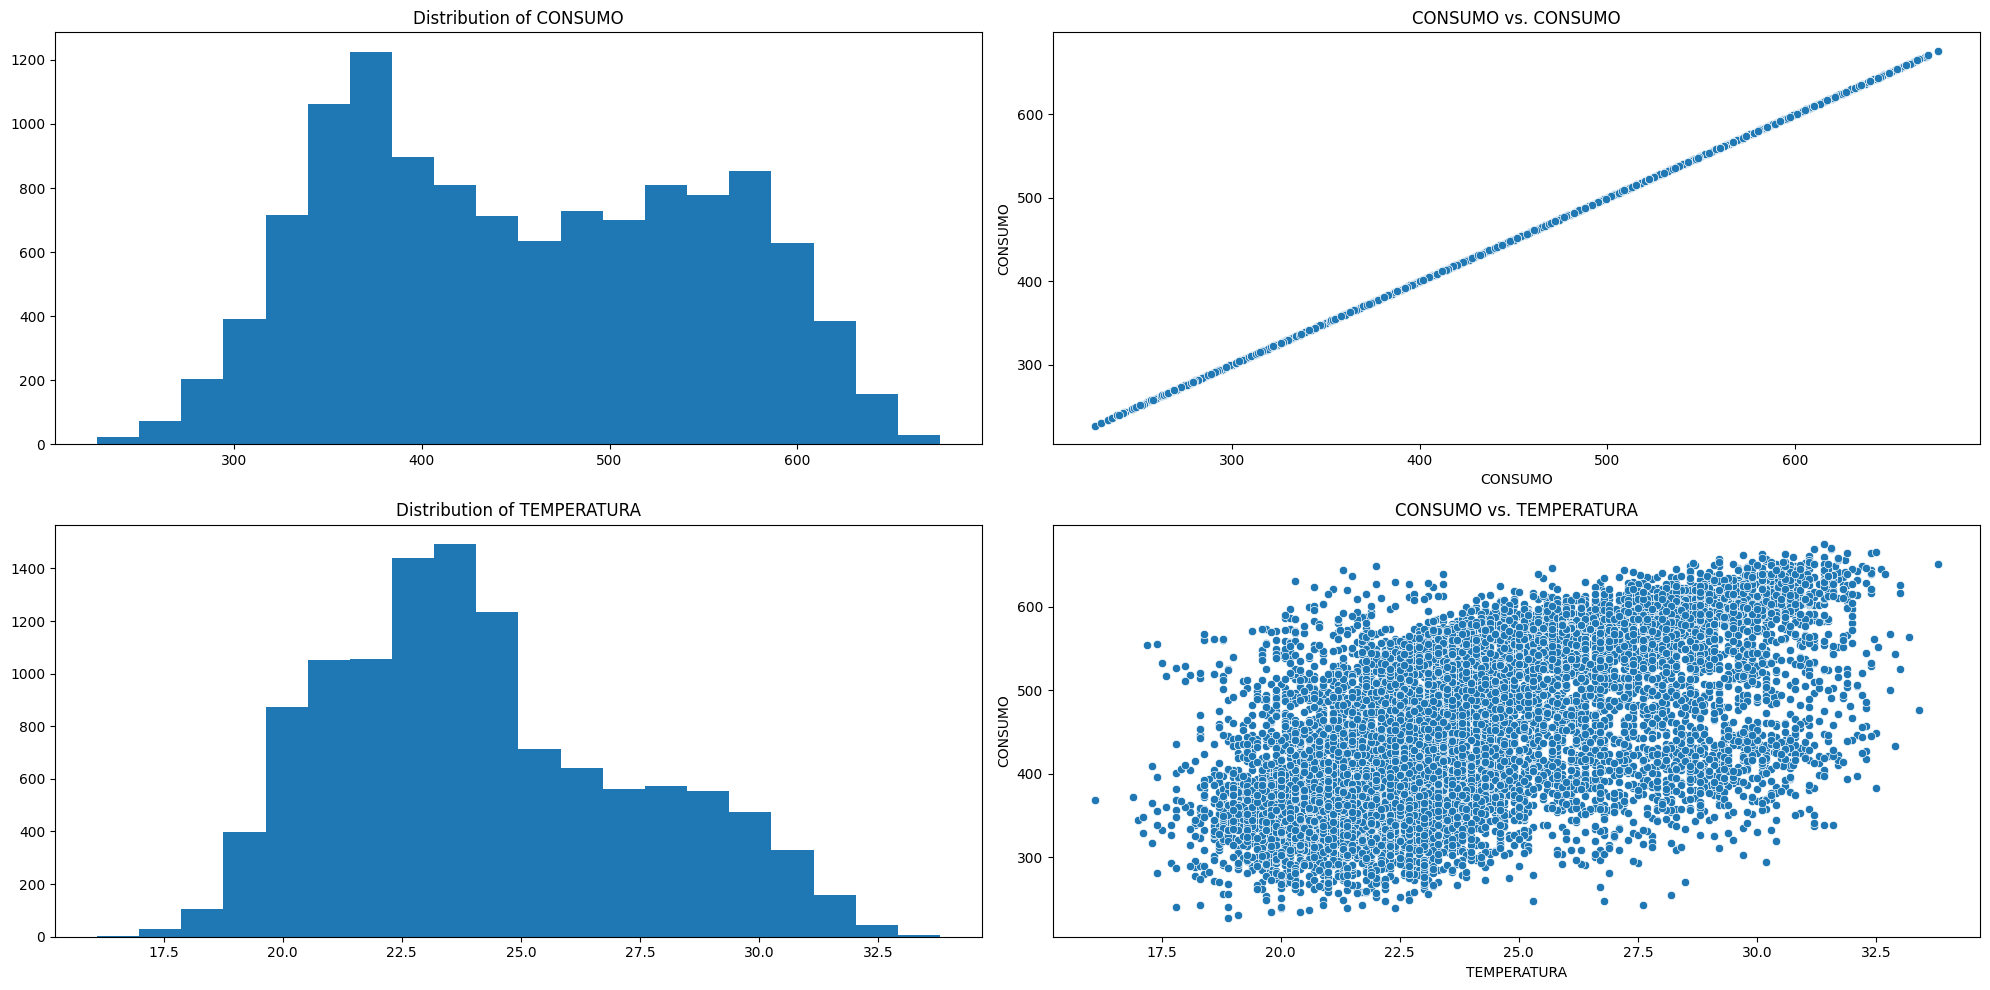

In [7]:
numerical_columns = ['CONSUMO', 'TEMPERATURA']

correlation_matrix = df[numerical_columns].corr()

plt.figure(figsize=(10, 8))

num_cols = 2  # columns per row
num_rows = (len(numerical_columns) * 2 + num_cols - 1) // num_cols # Calculate the rows needed.

# Create subplots in a grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(numerical_columns):
    # Histogram
    axes[i * 2].hist(df[col], bins=20)
    axes[i * 2].set_title(f'Distribution of {col}')

    # Scatterplot
    sns.scatterplot(x=col, y='CONSUMO', data=df, ax=axes[i * 2 + 1])
    axes[i * 2 + 1].set_title(f'CONSUMO vs. {col}')

# Remove any unused subplots
for j in range(len(numerical_columns) * 2, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Boxplots comparativos (para una variable numérica y una categórica) - Gráficos de barras o stacked charts


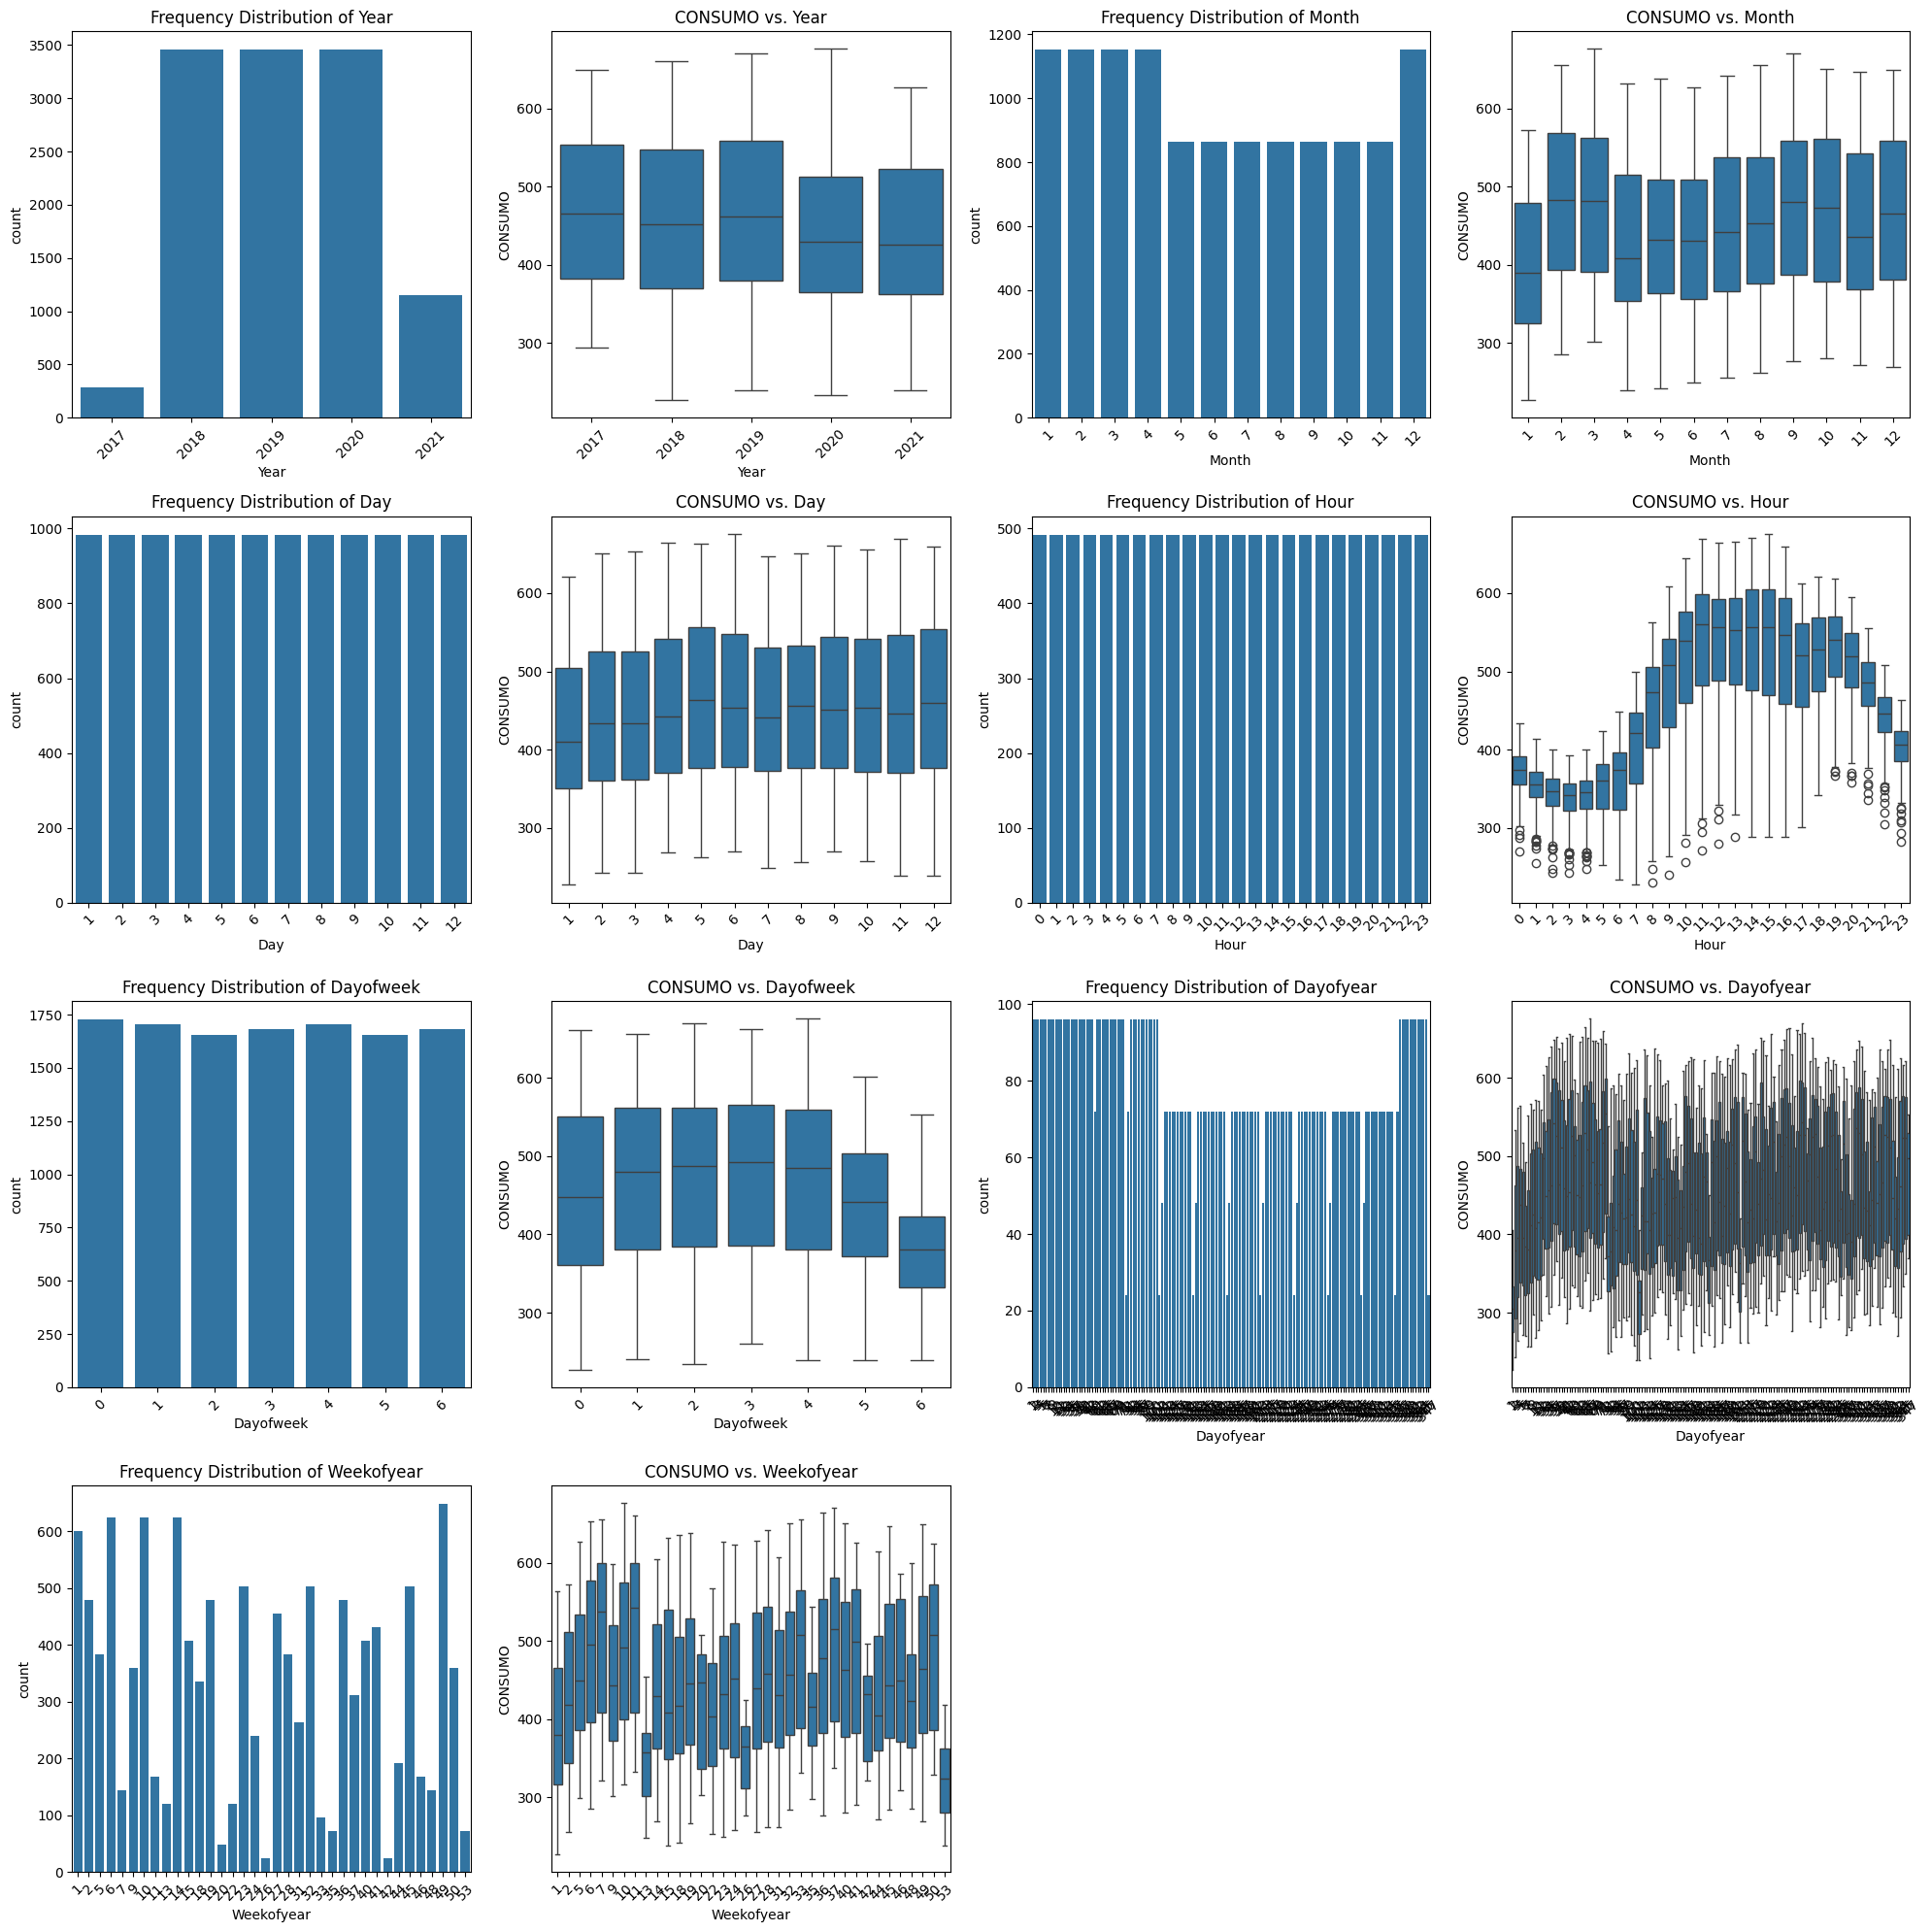

In [8]:
# Determine the number of rows needed for the subplots
num_cols = 4  # 4 columns per row
num_rows = (len(categorical_cols) * 2 + num_cols - 1) // num_cols # Calculate the rows needed.

# Create subplots in a grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(categorical_cols):
    # Countplot
    sns.countplot(x=col, data=df, ax=axes[i * 2])
    axes[i * 2].set_title(f'Frequency Distribution of {col}')
    axes[i * 2].tick_params(axis='x', rotation=45)  # Rotate x-axis labels if needed

    # Boxplot
    sns.boxplot(x=col, y='CONSUMO', data=df, ax=axes[i * 2 + 1])
    axes[i * 2 + 1].set_title(f'CONSUMO vs. {col}')
    axes[i * 2 + 1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels if needed

# Remove any unused subplots
for j in range(len(categorical_cols) * 2, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust subplot parameters to give specified padding.
plt.show()

# Interpretación de los resultados


# Conclusiones y reflexiones

- La correlación moderada entre temperatura y consumo, se logra evidenciar que la relación entre estas variables es de 0.59, lo que indica que a medida que la temperatura aumenta, el consumo de energía tiende a incrementarse, pero se debe tener en cuenta que no es el único factor determinante.
- La hora del día es la variable más influyente ya que se identificó que el consumo sigue un patrón horario marcado, con ciertos picos al día donde se incrementa considerablemente.
- Para los días de la semana se ve un impacto, especialmente los domingos ya que presentan un comportamiento diferente en el consumo, posiblemente debido a una menor actividad comercial e industrial.



## Impacto de la relación entre variables en el conjunto de datos

- La correlación entre temperatura y consumo refleja que en días más calurosos, los sistemas de enfriamiento contribuyen a un mayor uso de energía. Sin embargo, dado que la relación no es extremadamente fuerte, otros factores temporales y de comportamiento pueden tener un impacto más significativo.
- El hecho de que la hora del día sea la variable más relevante nos indica que el consumo sigue patrones predecibles, probablemente relacionados con los hábitos con respecto al consumo energético en distintos momentos del día.
- Los patrones semanales y la diferencia entre días ordinarios y festivos refuerzan la idea de que el consumo energético está fuertemente vinculado a la actividad comercial e industrial.


## Posibles hipótesis o próximos pasos para un análisis más profundo

- Exploración del consumo por franjas horarias específicas: Identificar los picos de consumo y analizar si hay oportunidades para optimizar la demanda energética.
- Se puede realizar una segmentación del consumo por tipo de usuario, con la finalidad de poder diferenciar entre consumo residencial, comercial e industrial para ver cómo varían los patrones.
- La incorporación de datos adicionales como por ejemplo humedad, velocidad del viento que puedan afectar la correlación con el consumo energético.